<a href="https://colab.research.google.com/github/potis/AISummit/blob/main/AI_Summit_2023_Part_1_MNIST_Class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Scope

Machine Learning models based on Deep Neural Networks behave unpredictably when presented with inputs thatdo not stem from the training distribution and sometimesmake egregiously wrong predictions with high confidence.
This undermines the trustworthiness of systems. Out-of-Distribution (OOD) detection mechanisms can be used to prevent errors by detecting inputs
that are so dissimilar from the training set that the model
can not be expected to make reliable predictions

These approaches are useful in production as well as training

> **Keep in mind this is a toy example.**

## Install necessary libraries


In [79]:
!pip install pip --upgrade
!pip install medmnist
!pip install autokeras
!pip install numpy
!pip install scikeras
!pip install -U -q --use-deprecated=legacy-resolver tf-models-official tensorflow
!pip install tensorflow_probability
!pip install --upgrade tf_agents

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Load the dataset

In [8]:
# Load the data
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import numpy as np
import time
import medmnist
import random
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import *
from sklearn import metrics as sklearn_metrics
import seaborn as sns
from tensorflow.keras.utils import to_categorical



def plot_confusion_matrix(y_true, y_pred):
    result = y_pred
    cf_matrix = sklearn_metrics.confusion_matrix(y_true, result)
    cfm_labels = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
    cfm_values = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    cfm_percent = ["{0:.2%}".format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(cfm_labels, cfm_values, cfm_percent)]
    labels = np.asarray(labels).reshape(2, 2)
    ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
    ax.set_title('Classifier\n\n')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values')
    # Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['False', 'True'])
    ax.yaxis.set_ticklabels(['False', 'True'])
    # Display the visualization of the Confusion Matrix.
    plt.show()

(train_data, train_labels), (test_data, test_labels) =keras.datasets.mnist.load_data()
# print(np.shape(train_data))
# print(np.shape(train_labels))

train_filter = np.where((train_labels == 0 ) | (train_labels == 5))
test_filter = np.where((test_labels == 0) | (test_labels == 5))
ood_filter= np.where((test_labels == 1) )
X_train, Y_train = train_data[train_filter], train_labels[train_filter]
Y_train[Y_train==5]=1
Y_train_c=to_categorical(Y_train)
X_test, Y_test = test_data[test_filter], test_labels[test_filter]
Y_test[Y_test==5]=1
ood_test= test_data[ood_filter]
# print(np.shape(Y_train))
# print(np.shape(X_train))
# print(Y_train.max())

## Show some samples image

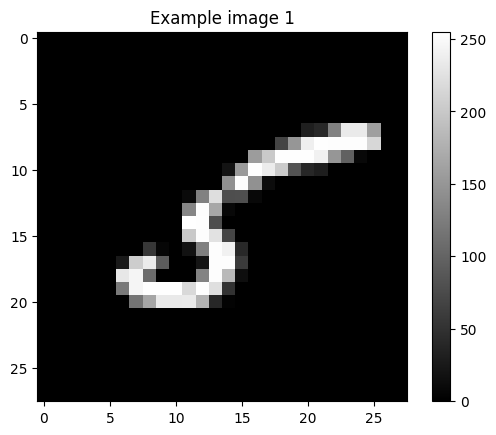

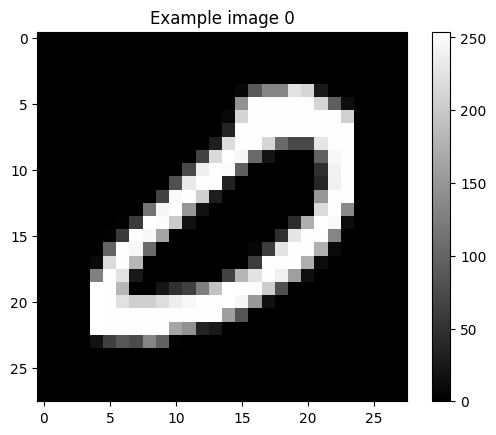

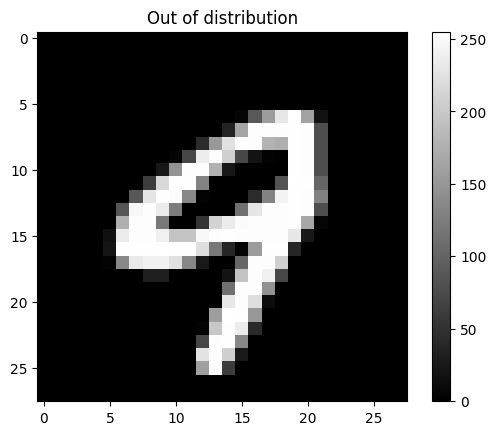

In [9]:
plt.figure()
plt.title(f'Example image {str(Y_train[2])}')
plt.imshow(X_train[2, :,:], cmap='gray')
plt.colorbar()
plt.grid(False)
plt.show()
plt.figure()
plt.title(f'Example image {str(Y_train[-3])}')
plt.imshow(X_train[-3, :,:], cmap='gray')
plt.colorbar()
plt.grid(False)
plt.show()
plt.figure()
plt.title(f'Out of distribution')

plt.imshow(ood_test[-1, :,:], cmap='gray')
plt.colorbar()
plt.grid(False)
plt.show()


## Create model


Let's build a simple classification model.
> Keep in mind that this is an example for demonstration purposes. The training does not follow best practices for training or performance evaluation

In [10]:
batch_size = 32
img_height = 28
img_width = 28


from tensorflow.keras import layers, models
from scikeras.wrappers import KerasClassifier

class MyModel(models.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.model = self.build_model()

    def build_model(self):
        model = models.Sequential()
        model.add(layers.Rescaling(1./255, input_shape=(28, 28, 1)))
        model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
        model.add(layers.MaxPooling2D())
        model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
        model.add(layers.MaxPooling2D())
        model.add(layers.Conv2D(128, 3, padding='same', activation='relu'))
        model.add(layers.MaxPooling2D())
        model.add(layers.Flatten())
        model.add(layers.Dense(16, activation='relu'))
        model.add(layers.Dropout(.25))
        model.add(layers.Dense(2, activation='softmax'))
        return model

    def call(self, inputs):
        return self.model(inputs)

model = MyModel()
model.build(((None,None,None, 1)))

model.summary()


model.compile(optimizer=tf.keras.optimizers.Adam(
              learning_rate=0.0001),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])
epochs=5

model.fit(
    X_train,
    Y_train_c,
    validation_split=0.3,
    epochs=epochs,
)



Model: "my_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 2)                 111154    
                                                                 
Total params: 111,154
Trainable params: 111,154
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
249/249 [==============================] - 14s 12ms/step - loss: 0.2750 - accuracy: 0.8992 - val_loss: 0.0321 - val_accuracy: 0.9941
Epoch 2/5
249/249 [==============================] - 2s 6ms/step - loss: 0.0359 - accuracy: 0.9909 - val_loss: 0.0218 - val_accuracy: 0.9935
Epoch 3/5
249/249 [==============================] - 2s 6ms/step - loss: 0.0189 - accuracy: 0.9956 - val_loss: 0.0120 - val_accuracy: 0.9956
Epoch 4/5
249/249 [==============================] - 2s 8ms/step - loss: 0.0137 - accuracy: 0.9962 - val_loss: 0.0138 - val_accuracy: 0.9953
Epoch 5/5
24

## Evaluate the model

(1872, 2)
(1872, 2)


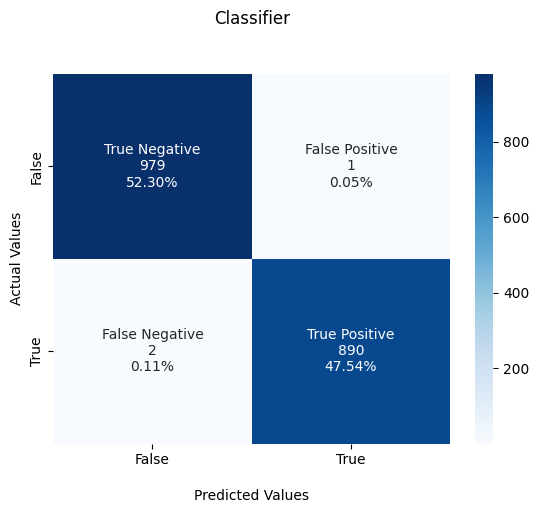

In [11]:
predictions=model(X_test)
predictions=predictions.numpy()
predictions_bin=predictions.argmax(axis=-1)
plot_confusion_matrix(Y_test, predictions_bin)

### Test model in a sample originating from the test set

(1, 2)
In-distribution sample


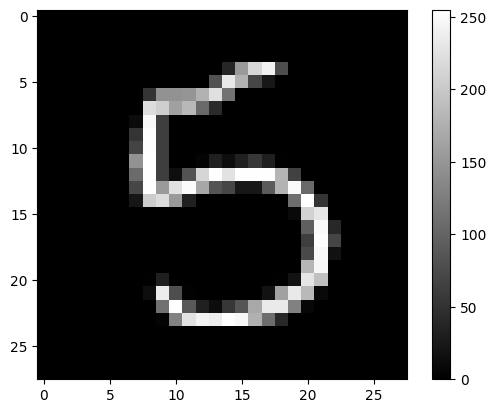

0.6180006
Rotating image 90 degrees


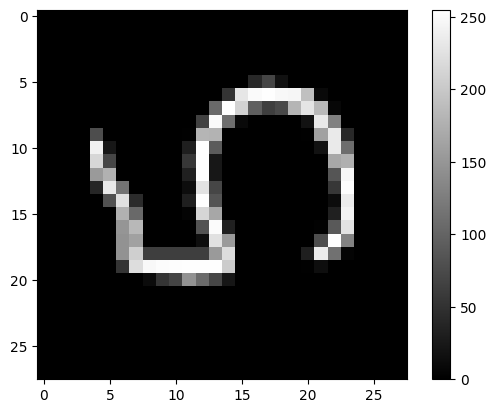

0.024244776
Fliping image upside down


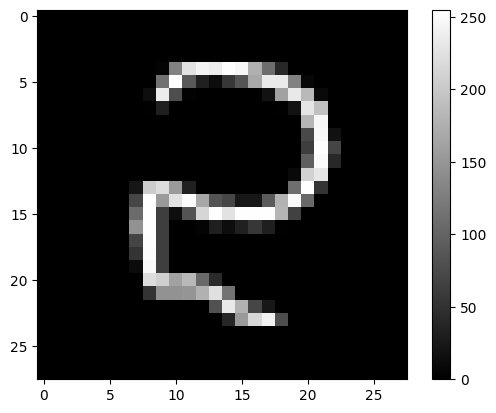

0.016562028
Invert Color


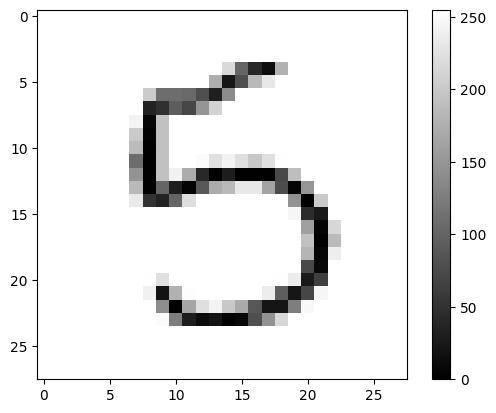

0.15820234


In [17]:
# Get a sample
example_case=10
sample=np.reshape(sample,(1,28,28))
predictions_sample=model(sample)
predictions_sample=predictions_sample.numpy()
print(np.shape(predictions_sample))
predictions_sample=predictions_sample[0,1]
print('In-distribution sample')
sample=X_test[example_case, :,:]
plt.figure()
plt.imshow(sample, cmap='gray')
plt.colorbar()
plt.grid(False)
plt.show()
print(predictions_sample)
# What if we just rotate?
print('Rotating image 90 degrees')

sample=X_test[example_case, :,:]
plt.figure()
plt.imshow(np.rot90(sample), cmap='gray')
plt.colorbar()
plt.grid(False)
plt.show()

rot_sample=np.rot90(X_test[example_case, :,:],1).reshape((1,28,28))
predictions_sample=model(rot_sample)
predictions_sample=predictions_sample.numpy()
predictions_sample=predictions_sample[0,1]
print(predictions_sample)
print('Fliping image upside down')
plt.figure()
plt.imshow(np.flipud(sample), cmap='gray')
plt.colorbar()
plt.grid(False)
plt.show()
rot_sample=np.flipud(X_test[example_case, :,:]).reshape((1,28,28))
predictions_sample=model(rot_sample)
predictions_sample=predictions_sample.numpy()
predictions_sample=predictions_sample[0,1]
print(predictions_sample)


print('Invert Color')
plt.figure()
plt.imshow(np.abs(255-sample), cmap='gray')
plt.colorbar()
plt.grid(False)
plt.show()
rot_sample=np.abs(255-sample).reshape((1,28,28))
predictions_sample=model(rot_sample)
predictions_sample=predictions_sample.numpy()
predictions_sample=predictions_sample[0,1]
print(predictions_sample)

> Image augmentation could address the above issue.




### Test model in out of distribution data (Deterministic Model)

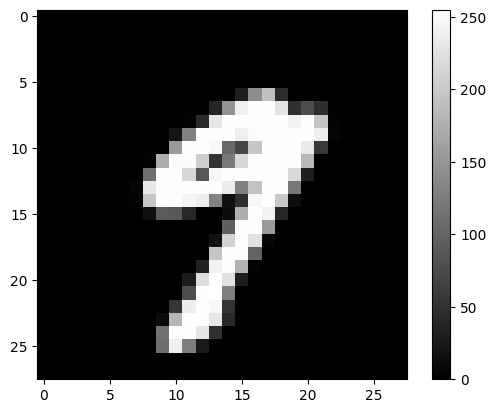

Predicted class: 1
0.6180006


In [18]:
# resnet_uncertainty = resnet_probs * (1 - resnet_probs)
# Get a sample
sample=ood_test[4, :,:]
plt.figure()
plt.imshow((sample), cmap='gray')
plt.colorbar()
plt.grid(False)
plt.show()
sample=np.reshape(sample,(1,28,28))
predictions=model(sample)
predictions=predictions.numpy()
print(f'Predicted class: {predictions.argmax()}')
predictions=predictions[0,1]
print(predictions)


## Monte Carlo dropout

- **During Training:** Regularizationto reduce overfitting and improve generalization error
- **During Inference:** MC Dropout is a mainstream “free lunch” method in medicalimaging for approximate Bayesian computations [ref](https://arxiv.org/pdf/2110.04286.pdf)

In [46]:
num_ensemble = 10
# Easy to implement, just change the network to training mode!
def mc_dropout_sampling(test_examples):
  # Enable dropout during inference.
  return model(test_examples, training=True)

### In distribution

True Class 0
0.0067411563
0.02012093
True Class 1
0.9977938
0.002372918


(0.0, 1.1)

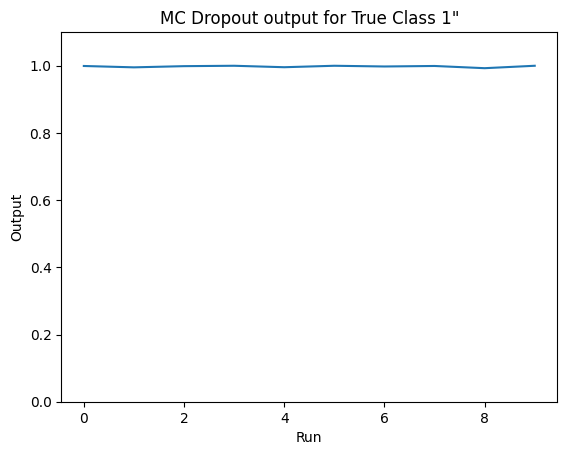

In [49]:
# Get a sample
sample=X_test[0,:,:]
print(f"True Class {Y_test[0]}")
sample=np.reshape(sample,(1,28,28))
dropout_samples = [mc_dropout_sampling(sample).numpy()[0,1] for _ in range(num_ensemble)]
print(np.array(dropout_samples).mean())
uncertainty = np.array(dropout_samples).std()
print(uncertainty)
# Get a sample
sample=X_test[10,:,:]
print(f"True Class {Y_test[10]}")
sample=np.reshape(sample,(1,28,28))
dropout_samples = [mc_dropout_sampling(sample).numpy()[0,1] for _ in range(num_ensemble)]
print(np.array(dropout_samples).mean())
uncertainty = np.array(dropout_samples).std()
print(uncertainty)

plt.title(f'MC Dropout output for True Class {Y_test[10]}"')
plt.plot(dropout_samples)
plt.xlabel('Run')
plt.ylabel('Output')
plt.ylim((0, 1.1))   # set the ylim to bottom, top


### Out of distribution example

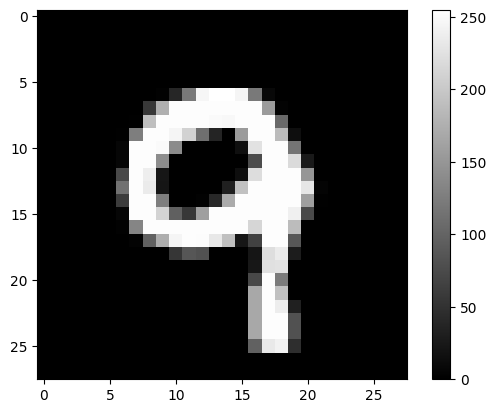

Prediction
0.35924506
Uncertainty
0.2736935


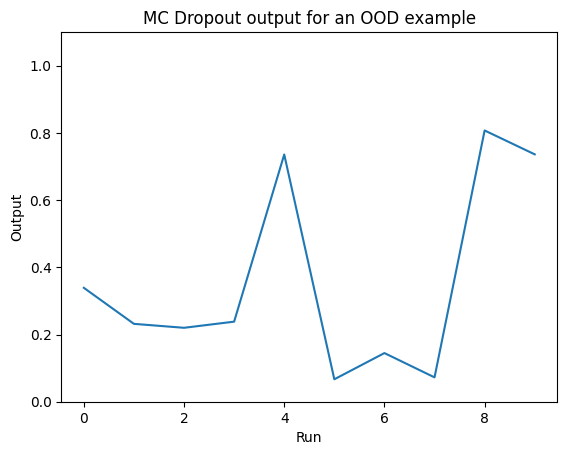

In [48]:
example=10
plt.figure()
plt.imshow(ood_test[example, :,:], cmap='gray')
plt.colorbar()
plt.grid(False)
plt.show()
sample_ood=ood_test[example,:,:]
sample_ood=np.reshape(sample_ood,(1,28,28))
dropout_samples_ood = [mc_dropout_sampling(sample_ood).numpy()[0,1] for _ in range(num_ensemble)]
plt.title('MC Dropout output for an OOD example')
plt.plot(dropout_samples_ood)
plt.xlabel('Run')
plt.ylabel('Output')
plt.ylim((0, 1.1))   # set the ylim to bottom, top

# print(dropout_samples_ood)
print("Prediction")
print(np.array(dropout_samples_ood).mean())
print("Uncertainty")
print(np.array(dropout_samples_ood).std())


> *TASK*: Try additional examples

## Deep Ensemble

Deep Ensembles are ensembles of DNNs trained on
the same dataset with different random parameter initialisations and data shuffling,  The ensemble
members can be interpreted as samples from different
modes of the Bayesian parameter posterior,
which allows their predictions to be more diverse compared
to unimodal approximate Bayesian approaches. They
have been shown to be a reliable and scalable approach for
improving both the predictive performance and quality of
uncertainty estimates of DNNs

In [43]:
num_ensemble=10
# Deep ensemble training
deep_ensemble = []
import random


for ivar in range(num_ensemble):
  print(f'{ivar}')
  tf.keras.utils.set_random_seed(random.randint(100,1000))
  temp_model= MyModel()
  temp_model.build(((None,None,None, 1)))
  temp_model.compile(optimizer='adam',
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])
  temp_model.reset_states()
  temp_model.fit(
    X_train,
    Y_train_c,
    validation_split=0.3,
    epochs=epochs)
  print(f'------')

  deep_ensemble.append(temp_model)

  del temp_model

0
Epoch 1/5
249/249 [==============================] - 6s 11ms/step - loss: 0.0523 - accuracy: 0.9838 - val_loss: 0.0156 - val_accuracy: 0.9953
Epoch 2/5
249/249 [==============================] - 2s 7ms/step - loss: 0.0097 - accuracy: 0.9965 - val_loss: 0.0075 - val_accuracy: 0.9979
Epoch 3/5
249/249 [==============================] - 2s 6ms/step - loss: 0.0048 - accuracy: 0.9989 - val_loss: 0.0031 - val_accuracy: 0.9988
Epoch 4/5
249/249 [==============================] - 2s 6ms/step - loss: 0.0027 - accuracy: 0.9990 - val_loss: 0.0061 - val_accuracy: 0.9979
Epoch 5/5
249/249 [==============================] - 2s 6ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0069 - val_accuracy: 0.9979
------
1
Epoch 1/5
249/249 [==============================] - 4s 7ms/step - loss: 0.0765 - accuracy: 0.9703 - val_loss: 0.0323 - val_accuracy: 0.9906
Epoch 2/5
249/249 [==============================] - 2s 8ms/step - loss: 0.0168 - accuracy: 0.9942 - val_loss: 0.0120 - val_accuracy: 0.9965
E

### In distribution

True Class 0
2.6497329e-08
6.031296e-08
True Class 1
0.9999999
1.8467824e-07


(0.0, 1.1)

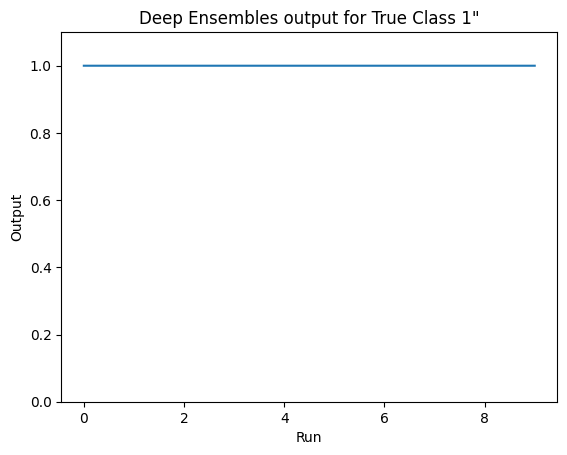

In [45]:
# Get a sample
sample=X_test[0,:,:]
print(f"True Class {Y_test[0]}")
sample=np.reshape(sample,(1,28,28))
ensemble_preds_samples = [model_x(sample).numpy()[0,1] for model_x in (deep_ensemble)]
print(np.array(ensemble_preds_samples).mean())
uncertainty = np.array(ensemble_preds_samples).std()
print(uncertainty)
# Get a sample
sample=X_test[10,:,:]
print(f"True Class {Y_test[10]}")
sample=np.reshape(sample,(1,28,28))
ensemble_preds_samples = [model_x(sample).numpy()[0,1] for model_x in (deep_ensemble)]
print(np.array(ensemble_preds_samples).mean())
uncertainty = np.array(ensemble_preds_samples).std()
print(uncertainty)
plt.title(f'Deep Ensembles output for True Class {Y_test[10]}"')
plt.plot(ensemble_preds_samples)
plt.xlabel('Run')
plt.ylabel('Output')
plt.ylim((0, 1.1))   # set the ylim to bottom, top


### Out of distribution example

```
# This is formatted as code
```



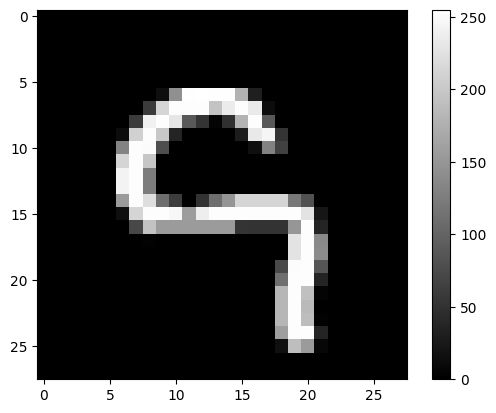

Prediction
0.9999999
Uncertainty
1.8467824e-07


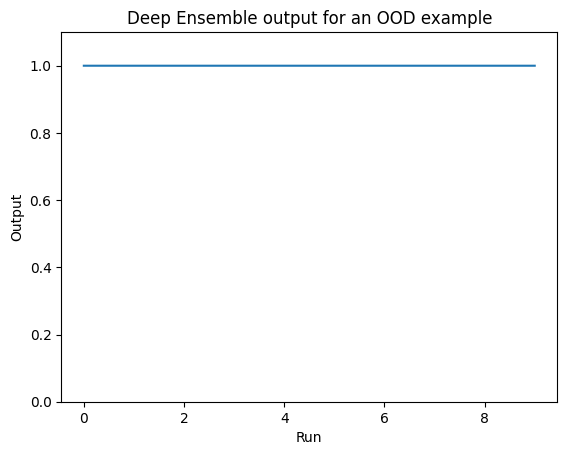

In [51]:
example=11
plt.figure()
plt.imshow(ood_test[example, :,:], cmap='gray')
plt.colorbar()
plt.grid(False)
plt.show()
sample_ood=ood_test[example,:,:]
sample_ood=np.reshape(sample_ood,(1,28,28))
ensemble_preds_samples = [model_x(sample).numpy()[0,1] for model_x in (deep_ensemble)]
plt.title('Deep Ensemble output for an OOD example')
plt.plot(ensemble_preds_samples)
plt.xlabel('Run')
plt.ylabel('Output')
plt.ylim((0, 1.1))   # set the ylim to bottom, top

# print(dropout_samples_ood)
print("Prediction")
print(np.array(ensemble_preds_samples).mean())
print("Uncertainty")
print(np.array(ensemble_preds_samples).std())

## SNGP Spectral-normalized Neural Gaussian Process

SNGP is a simple approach to improve a deep classifier's uncertainty quality while maintaining a similar level of accuracy and latency. Given a deep residual network, SNGP makes two simple changes to the model:

- It applies spectral normalization to the hidden residual layers.
- It replaces the Dense output layer with a Gaussian process layer.


#### Advantages
It is a single-model method—it does not rely on ensemble averaging. Therefore, SNGP has a similar level of latency as a single deterministic network, and can be scaled easily to large datasets
It has strong out-of-domain detection performance due to the distance-awareness property.

In [52]:
import official.nlp.modeling.layers as nlp_layers
epochs=10
class simplenet(tf.keras.Model):
    """Defines a multi-layer residual network."""
    def __init__(self, num_classes=1, num_layers=1, num_hidden=32,
                 dropout_rate=0.1, **classifier_kwargs):
        super().__init__()
        # Define class meta data.
        self.num_hidden = num_hidden
        self.num_layers = num_layers
        self.dropout_rate = dropout_rate
        self.classifier_kwargs = classifier_kwargs

        # Define the layers.
        self.input_layer = tf.keras.layers.Input((None,None))
        self.normalize_layer = tf.keras.layers.Rescaling(1/255.)
        self.reshape_layer = tf.keras.layers.Reshape((28, 28, 1))
        self.conv1 = tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu')
        self.maxpool1 = tf.keras.layers.MaxPool2D(2)
        self.conv2 = tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu')
        self.maxpool2 = tf.keras.layers.MaxPool2D(2)
        self.conv3 = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')
        self.maxpool3 = tf.keras.layers.MaxPool2D(2)
        self.flatten = tf.keras.layers.Flatten()
        self.dense = tf.keras.layers.Dense(num_hidden)
        self.dense_layers = [self.make_dense_layer() for _ in range(num_layers)]
        self.classifier = self.make_output_layer(num_classes)

    def call(self, inputs):
        # Project the 2D input data to high dimension.
        normalized = self.normalize_layer(inputs)
        reshape_layer=self.reshape_layer(normalized)
        conv1 = self.conv1(reshape_layer)
        maxpool1 = self.maxpool1(conv1)
        conv2 = self.conv2(maxpool1)
        maxpool2 = self.maxpool2(conv2)
        conv3 = self.conv3(maxpool2)
        maxpool3 = self.maxpool3(conv3)
        flattened = self.flatten(maxpool3)
        dense = self.dense(flattened)

        # Compute the ResNet hidden representations.
        for i in range(self.num_layers):
            resid = self.dense_layers[i](dense)
            resid = tf.keras.layers.Dropout(self.dropout_rate)(resid)
            dense += resid

        return self.classifier(dense)

    def make_dense_layer(self):
        """Use the Dense layer as the hidden layer."""
        return tf.keras.layers.Dense(self.num_hidden, activation="relu")

    def make_output_layer(self, num_classes):
        """Use the Dense layer as the output layer."""
        return tf.keras.layers.Dense(
            num_classes, **self.classifier_kwargs)

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [76]:
class simplenetSNGP(simplenet):
  def __init__(self, spec_norm_bound=0.9, **kwargs):
    self.spec_norm_bound = spec_norm_bound
    super().__init__(**kwargs)

  def make_dense_layer(self):
    """Applies spectral normalization to the hidden layer."""
    dense_layer = super().make_dense_layer()
    return nlp_layers.SpectralNormalization(
        dense_layer, norm_multiplier=self.spec_norm_bound)

  def make_output_layer(self, num_classes):
    """Uses Gaussian process as the output layer."""
    return nlp_layers.RandomFeatureGaussianProcess(
        2,
        gp_cov_momentum=-1,
        **self.classifier_kwargs)

  def call(self, inputs, training=False, return_covmat=False):
    # Gets logits and a covariance matrix from the GP layer.
    logits, covmat = super().call(inputs)

    # Returns only logits during training.
    if not training and return_covmat:
      return logits, covmat

    return logits
# sngp_model = simplenetSNGP(**resnet_config)
# sngp_model.build((None, None))
# sngp_model.summary()




class ResetCovarianceCallback(tf.keras.callbacks.Callback):

  def on_epoch_begin(self, epoch, logs=None):
    """Resets covariance matrix at the beginning of the epoch."""
    if epoch > 0:
      self.model.classifier.reset_covariance_matrix()
class DeepResNetSNGPWithCovReset(simplenetSNGP):
  def fit(self, *args, **kwargs):
    """Adds ResetCovarianceCallback to model callbacks."""
    kwargs["callbacks"] = list(kwargs.get("callbacks", []))
    kwargs["callbacks"].append(ResetCovarianceCallback())

    return super().fit(*args, **kwargs)
resnet_config = dict(num_classes=2)
sngp_model = simplenetSNGP(**resnet_config)
sngp_model.build((None,None, None,1))
sngp_model.summary()

loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
metrics = tf.keras.metrics.CategoricalAccuracy(),
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-4)
train_config = dict(loss=loss, metrics=metrics, optimizer=optimizer)
sngp_model.compile(**train_config)
sngp_model.fit(
    X_train,
    Y_train_c,
    validation_split=0.3,
    epochs=10)

Model: "simplenet_sngp_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_17 (Rescaling)    multiple                  0         
                                                                 
 reshape_2 (Reshape)         multiple                  0         
                                                                 
 conv2d_51 (Conv2D)          multiple                  160       
                                                                 
 max_pooling2d_51 (MaxPoolin  multiple                 0         
 g2D)                                                            
                                                                 
 conv2d_52 (Conv2D)          multiple                  4640      
                                                                 
 max_pooling2d_52 (MaxPoolin  multiple                 0         
 g2D)                                             

In [77]:
def compute_posterior_mean_probability(logits, covmat, lambda_param=np.pi / 8.):
  # Computes uncertainty-adjusted logits using the built-in method.
  logits_adjusted = nlp_layers.gaussian_process.mean_field_logits(
      logits, covmat, mean_field_factor=lambda_param)

  return tf.nn.softmax(logits_adjusted, axis=-1)




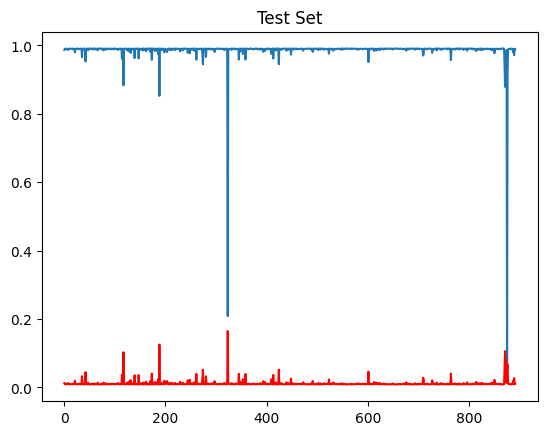

(1009,)


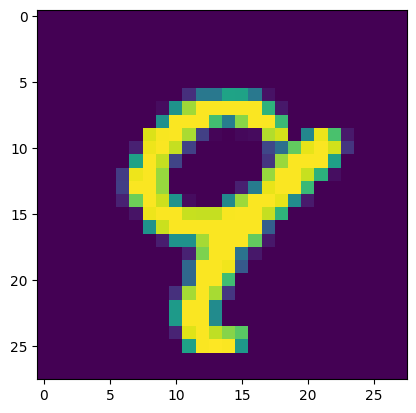

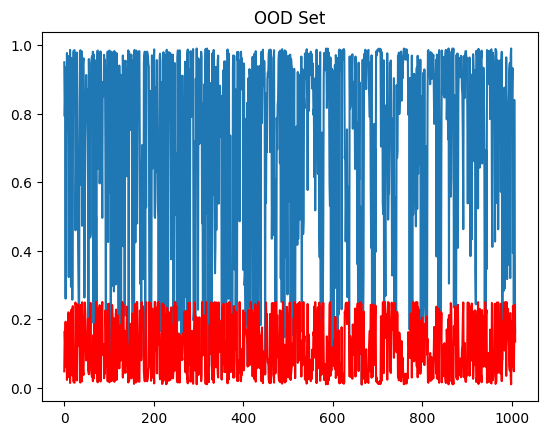

In [78]:
test_filter = np.where((Y_test == 1))
X_test_0=X_test[test_filter]
sngp_logits, sngp_covmat = sngp_model(X_test_0, return_covmat=True)
sngp_probs = compute_posterior_mean_probability(sngp_logits, sngp_covmat)
sngp_probs=sngp_probs[:,1]
# print(np.shape(sngp_probs))
# print((sngp_probs))
# uncertainty = sngp_probs * (1. - sngp_probs)
# print((uncertainty))
plt.plot(sngp_probs)
uncertainty = sngp_probs * (1. - sngp_probs)
plt.plot(uncertainty, c='r')
plt.title('Test Set')
plt.show()


### Out of distribution example



In [ ]:
sngp_logits_ood, sngp_covmat_ood = sngp_model(ood_test, return_covmat=True)
sngp_probs_ood = compute_posterior_mean_probability(sngp_logits_ood, sngp_covmat_ood)[:,1]
print(np.shape(sngp_probs_ood))
# print((sngp_probs_ood))
# uncertainty = sngp_probs_ood * (1. - sngp_probs_ood)
# print((uncertainty))

plt.imshow(ood_test[80,:,:])
plt.show()
plt.plot(sngp_probs_ood)
uncertainty = sngp_probs_ood * (1. - sngp_probs_ood)
plt.plot(uncertainty, c='r')
plt.title('OOD Set')
plt.show()

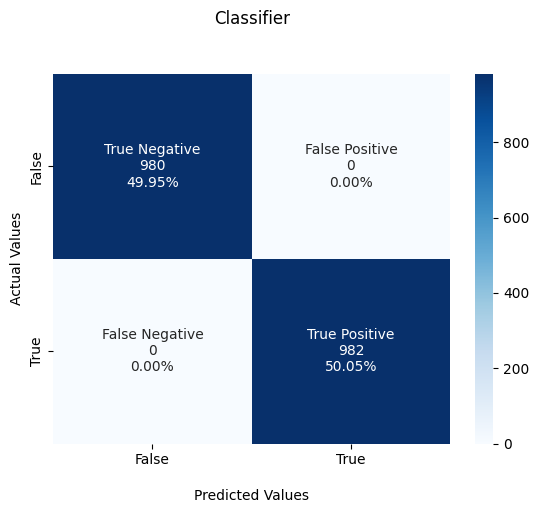

In [ ]:
sngp_logits, sngp_covmat = sngp_model(X_test, return_covmat=True)
sngp_probs = compute_posterior_mean_probability(sngp_logits, sngp_covmat)


plot_confusion_matrix(Y_test,sngp_probs.numpy().argmax(axis=-1) )

## Bayesian Neural Network -Variational inference (VI) as an approximative Bayes approach

Now we will train a bayesian neural network via variational inference. We again use a CNN with two convolutional blocks, followed by maxpooling layers. The setting is the same as above.



The main idea of the Bayes approach in DL is that with BNNs, each weight is replaced
by a distribution. Normally, this is quite a complicated distribution, and this distribution
isn’t independent among different weights. The idea behind the VI Bayes
method is that the complicated posterior distributions of the weights are approximated
by a simple distribution called variational distribution.

### In distribution

In [95]:
import tensorflow_probability as tfp
from tensorflow.python.framework.ops import disable_eager_execution
from tensorflow.keras.utils import to_categorical

disable_eager_execution()
kernel_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (X_train.shape[0] *1.0)

model_vi = Sequential()
model_vi.add(layers.Rescaling(1./255, input_shape=(28, 28, 1)))
model_vi.add(tfp.layers.Convolution2DFlipout(16,kernel_size=(3,3),padding="same", activation = 'relu', kernel_divergence_fn=kernel_divergence_fn,input_shape=(28,28,1)))
model_vi.add(tf.keras.layers.MaxPooling2D((2,2)))
model_vi.add(tfp.layers.Convolution2DFlipout(32,kernel_size=(3,3),padding="same", activation = 'relu', kernel_divergence_fn=kernel_divergence_fn))
model_vi.add(tf.keras.layers.MaxPooling2D((2,2)))
model_vi.add(tfp.layers.Convolution2DFlipout(64,kernel_size=(3,3),padding="same", activation = 'relu', kernel_divergence_fn=kernel_divergence_fn))
model_vi.add(tf.keras.layers.MaxPooling2D((2,2)))
model_vi.add(tf.keras.layers.Flatten())
model_vi.add(tfp.layers.DenseFlipout(32, activation = 'relu', kernel_divergence_fn=kernel_divergence_fn))
model_vi.add(tfp.layers.DenseFlipout(2, activation = 'softmax', kernel_divergence_fn=kernel_divergence_fn))

X_train=X_train.reshape((-1,28,28,1))

model_vi.compile(tf.keras.optimizers.legacy.Adam(learning_rate=0.001),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['categorical_accuracy'])
epochs=10
print(np.shape(Y_train))

print(np.shape(Y_train))
model_vi.fit(
    X_train,
    Y_train_c,
    validation_split=0.3,
    epochs=epochs,
)

/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/layers/util.py:95: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/layers/util.py:105: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


(11344,)
(11344,)
Train on 7940 samples, validate on 3404 samples
Epoch 1/10
7904/7940 [============================>.] - ETA: 0s - loss: 9.1406 - categorical_accuracy: 0.9346

/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7940/7940 [==============================] - 3s 381us/sample - loss: 9.1388 - categorical_accuracy: 0.9349 - val_loss: 8.7041 - val_categorical_accuracy: 0.9924
Epoch 2/10
7940/7940 [==============================] - 2s 295us/sample - loss: 8.3920 - categorical_accuracy: 0.9928 - val_loss: 8.0833 - val_categorical_accuracy: 0.9927
Epoch 3/10
7940/7940 [==============================] - 3s 368us/sample - loss: 7.7559 - categorical_accuracy: 0.9948 - val_loss: 7.4485 - val_categorical_accuracy: 0.9935
Epoch 4/10
7940/7940 [==============================] - 5s 665us/sample - loss: 7.1325 - categorical_accuracy: 0.9969 - val_loss: 6.8262 - val_categorical_accuracy: 0.9950
Epoch 5/10
7940/7940 [==============================] - 3s 327us/sample - loss: 6.5198 - categorical_accuracy: 0.9969 - val_loss: 6.2230 - val_categorical_accuracy: 0.9959
Epoch 6/10
7940/7940 [==============================] - 2s 301us/sample - loss: 5.9348 - categorical_accuracy: 0.9961 - val_loss: 5.6549 - val_categori

### In distribution

(0.0, 1.0)

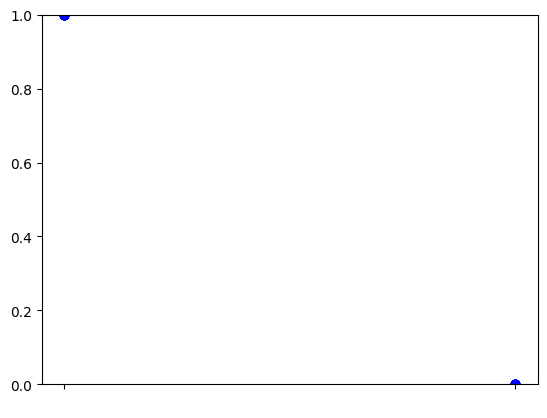

In [93]:

for i in range(0,50):
  plt.scatter(range(0,2),model_vi.predict(X_test[0:1].reshape(1,28,28,1)),c="blue",alpha=0.2)
plt.xticks(range(0,2),labels=np.repeat(" ",2))
plt.ylim([0,1])


### Out of distribution example


(0.0, 1.0)

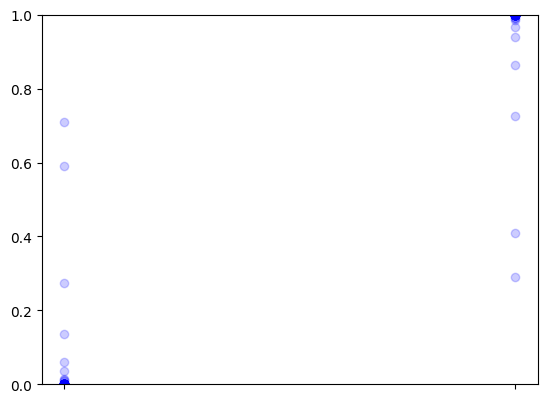

In [94]:

for i in range(0,50):
  plt.scatter(range(0,2),model_vi.predict(ood_test[0:1].reshape(1,28,28,1)),c="blue",alpha=0.2)
plt.xticks(range(0,2),labels=np.repeat(" ",2))
plt.ylim([0,1])


# Whats Next?


1. Try the same experiment with different digits!
2. What about a medical dataset?
  - Create a copy of the notebook
  - Use the following code to load the data
  ```
    import os
    import matplotlib.pyplot as plt
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers
    from tensorflow.keras.models import Sequential
    import numpy as np
    import time
    import medmnist
    import random
    from sklearn.calibration import CalibratedClassifierCV
    from medmnist import INFO, Evaluator
    from medmnist.info import DEFAULT_ROOT
    from sklearn.metrics import *
    from sklearn import metrics as sklearn_metrics
    import seaborn as sns
    data_flag_class3 = "pathmnist"
    data_flag_class2 = "breastmnist"
    data_flag_class1 = "pneumoniamnist"

    output_root ="./ood"

    input_root = DEFAULT_ROOT

    def plot_confusion_matrix(y_true, y_pred):
        result = np.zeros(np.shape(y_pred)[0])
        result[y_pred[:,0] < 0.5] = 0
        result[y_pred[:,0] >= 0.5] = 1
        cf_matrix = sklearn_metrics.confusion_matrix(y_true, result)

        cfm_labels = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
        cfm_values = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
        cfm_percent = ["{0:.2%}".format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
        labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(cfm_labels, cfm_values, cfm_percent)]
        labels = np.asarray(labels).reshape(2, 2)

        ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
        ax.set_title('Classifier\n\n')
        ax.set_xlabel('\nPredicted Values')
        ax.set_ylabel('Actual Values')

        # Ticket labels - List must be in alphabetical order
        ax.xaxis.set_ticklabels(['False', 'True'])
        ax.yaxis.set_ticklabels(['False', 'True'])

        # Display the visualization of the Confusion Matrix.
        plt.show()
    def unison_shuffled_copies(a, b):
        assert len(a) == len(b)
        p = np.random.permutation(len(a))
        return a[p], b[p]

    info = INFO[data_flag_class1]
    task = info['task']
    _ = getattr(medmnist, INFO[data_flag_class1]['python_class'])(
            split="train", root=input_root, download=True)

    output_root = os.path.join(output_root, data_flag_class1, time.strftime("%y%m%d_%H%M%S"))
    if not os.path.isdir(output_root):
        os.makedirs(output_root)

    info = INFO[data_flag_class2]
    task = info['task']
    _ = getattr(medmnist, INFO[data_flag_class2]['python_class'])(
            split="train", root=input_root, download=True)

    output_root = os.path.join(output_root, data_flag_class2, time.strftime("%y%m%d_%H%M%S"))

    info = INFO[data_flag_class3]
    task = info['task']
    _ = getattr(medmnist, INFO[data_flag_class3]['python_class'])(
            split="train", root=input_root, download=True)

    output_root = os.path.join(output_root, data_flag_class3, time.strftime("%y%m%d_%H%M%S"))
    if not os.path.isdir(output_root):
        os.makedirs(output_root)

    npz_file_class1 = np.load(os.path.join(input_root, "{}.npz".format(data_flag_class1)))
    npz_file_class2 = np.load(os.path.join(input_root, "{}.npz".format(data_flag_class2)))
    npz_file_class3 = np.load(os.path.join(input_root, "{}.npz".format(data_flag_class3)))
    ood_test = npz_file_class3['train_images'][:580,...]
    ood_test=ood_test[:,:,:,0:1]
    print(np.shape(ood_test))
    X_train = np.concatenate((npz_file_class1['train_images'][:580,...], npz_file_class2['train_images']), axis=0)
    Y_train =np.concatenate((np.zeros(np.shape(npz_file_class1['train_images'][:580,...])[0]), np.ones(np.shape(npz_file_class2['train_images'])[0])), axis=0)
    X_train,Y_train= unison_shuffled_copies(X_train, Y_train)
    X_test = np.concatenate((npz_file_class1['test_images'][:80,...], npz_file_class2['test_images']), axis=0)
    Y_test =np.concatenate((np.zeros(np.shape(npz_file_class1['test_images'][:80,...])[0]), np.ones(np.shape(npz_file_class2['test_images'])[0])), axis=0)
  ```
